### 載入所需的Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List

### 載入資料

In [2]:
sms_data = pd.read_csv("data/Day17_spam.csv", encoding='ISO-8859-1', usecols = ['v1','v2'])
# sms_data = sms_data.iloc[:, :2]
sms_data.columns = ["label", "content"]
sms_data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# check how many spams and hams
sms_data.groupby("label").count()

,content
label,
ham,4825
spam,747


In [4]:
# change label from string to number
# "ham" --> 0, "spam" --> 1

sms_data["label"] = sms_data["label"].replace("ham", 0)
sms_data["label"] = sms_data["label"].replace("spam", 1)

sms_data.head()

,label,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 切分資料
將資料依據label比例切分為training data與testing data

In [5]:
sms_train, sms_test = train_test_split(sms_data, test_size=0.2, random_state=42)
sms_train = sms_train.reset_index(drop=True)
sms_test = sms_test.reset_index(drop=True)

print(sms_train.groupby("label").count())
print(sms_test.groupby("label").count())

       content
label         
0         3860
1          597
       content
label         
0          965
1          150


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [6]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    # make all content to lowercase and remove all punctuations
    for i in range(len(df)):
        df.loc[i, "content"] = re.sub(r"[\W\d]+", " ", df.loc[i, "content"].lower())
    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())

Train:
   label                                            content
0      0  no i m in the same boat still here at my moms ...
1      1   bank of granite issues strong buy explosive p...
2      0     they r giving a second chance to rahul dengra 
3      0           o i played smash bros lt gt religiously 
4      1  private your account statement for shows un re...
Test:
   label                                            content
0      0  funny fact nobody teaches volcanoes erupt tsun...
1      0  i sent my scores to sophas and i had to do sec...
2      1  we know someone who you know that fancies you ...
3      0  only if you promise your getting out as soon a...
4      1  congratulations ur awarded either å of cd gift...


In [7]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

7765

### TF-IDF
可以發現總共有7765個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [47]:
vectorizer = TfidfVectorizer()

n = 2000
tf_idf_train = vectorizer.fit_transform(x_train)
tfidf_train = np.argsort(-tf_idf_train.toarray())[:, :2000]

tf_idf_test = vectorizer.transform(x_test)
tfidf_test = np.argsort(-tf_idf_test.toarray())[:, :2000]

print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)

Number of unique word: 6910


(array([[3863,  666, 3747, ..., 6129, 6127, 6152],
        [ 929, 2458, 3875, ..., 6130, 6129, 6127],
        [1468, 4715, 2382, ..., 6153, 6101, 6099],
        ...,
        [5492, 5493, 4520, ..., 6101, 6099, 6071],
        [3057, 5191, 4023, ..., 6100, 6098, 6070],
        [2854, 2058, 3661, ..., 6151, 6099, 6097]]),
 array([[6215, 3883, 1981, ..., 6125, 6150, 6098],
        [5111, 5106, 4897, ..., 6134, 6133, 6132],
        [6628, 2590, 2009, ..., 6127, 6125, 6150],
        ...,
        [5943, 5439, 3692, ..., 6126, 6151, 6099],
        [1644, 2635, 2353, ..., 6152, 6100, 6098],
        [ 604, 3921, 3442, ..., 6127, 6152, 6100]]))

### 建立共現矩陣

In [55]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    # initialize co-occurrence matrix
    co_matrix = np.zeros((len(vocab_list), len(vocab_list)), dtype=int)
    
    for idx, sms in enumerate(corpus):
        sms_ids = [word2idx[word] for word in sms.split() if word in word2idx]
        for center_idx, center_word_id in enumerate(sms_ids):
            left_idx = center_idx - window_size if center_idx - window_size >= 0 else 0
            right_idx = center_idx + window_size if center_idx + window_size < len(sms_ids) \
                else len(sms_ids)-1
            
            for neighbor_idx in range(left_idx, right_idx):
                if neighbor_idx == center_idx:
                    continue
                else:
                    co_matrix[center_word_id, sms_ids[neighbor_idx]] += 1
        
        if verbose:
            if idx != 0 and idx%500 == 0:
                    print(f"finishing {idx+1}/{len(corpus)}")
    print("Done")
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        for i in range(len(vocab_list)):
            co_matrix[i, i] = 1.0
        
    return co_matrix

co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_,
                            window_size=3, use_weighting=True, verbose=True)

co_matrix

finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

### 建立PPMI矩陣
$$
\begin{aligned}
&PMI(x,y) = log_2\frac{P(x,y)}{P(x)P(y)} = log_2\frac{C(x,y)N}{C(x)C(y)} \\
&PPMI(x,y) = max(0,PMI(x,y))
\end{aligned}
$$

In [56]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    M = np.zeros((co_matrix.shape[0], co_matrix.shape[1]))
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    
    cnt = 0
    total = co_matrix.shape[0]*co_matrix.shape[1]
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2((co_matrix[i, j] * N) / (S[i]*S[j] + eps) )
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10000000 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=True)
ppmi_matrix

<ipython-input-56-d2bef022a6f4>:13: RuntimeWarning: divide by zero encountered in log2
  pmi = np.log2((co_matrix[i, j] * N) / (S[i]*S[j] + eps) )


10000000/47748100 Done
20000000/47748100 Done
30000000/47748100 Done
40000000/47748100 Done
47748100/47748100 Done


array([[11.11613449,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 12.86507272,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 11.11613449, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 12.86507272,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         7.18246821,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 12.86507272]])

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

Number of components = 300 and explained variance = 0.9742254482211364
Number of components = 310 and explained variance = 0.9749918252651769
Number of components = 320 and explained variance = 0.9757118717118747
Number of components = 330 and explained variance = 0.976390641847342
Number of components = 340 and explained variance = 0.9770315893089634
Number of components = 350 and explained variance = 0.9776426782989679


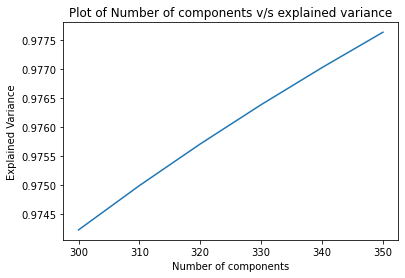

In [62]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(300,360,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim, n_iter=7, random_state=42)
    svd.fit(co_matrix)
    var_sum = svd.explained_variance_ratio_.sum()
    variance_sum.append(var_sum)
    print(f"Number of components = {dim} and explained variance = {var_sum}")
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

Number of components = 10 and explained variance = 0.02932986931519955
Number of components = 20 and explained variance = 0.046664293562522344
Number of components = 30 and explained variance = 0.06213456884783337
Number of components = 40 and explained variance = 0.07627650686768539
Number of components = 50 and explained variance = 0.0896193557474801
Number of components = 60 and explained variance = 0.10229607650377617
Number of components = 70 and explained variance = 0.1143780454295464
Number of components = 80 and explained variance = 0.12589720782861832
Number of components = 90 and explained variance = 0.13700466282501397
Number of components = 100 and explained variance = 0.14784280676875033
Number of components = 110 and explained variance = 0.15832453607160354
Number of components = 120 and explained variance = 0.16846247796724254
Number of components = 130 and explained variance = 0.17839316426007762
Number of components = 140 and explained variance = 0.18796255642878895


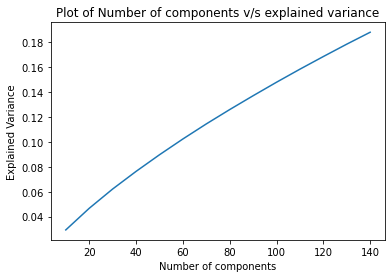

In [58]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim, n_iter=7, random_state=42)
    svd.fit(ppmi_matrix)
    var_sum = svd.explained_variance_ratio_.sum()
    variance_sum.append(var_sum)
    print(f"Number of components = {dim} and explained variance = {var_sum}")
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [67]:
# choose 350 as final dimension to reduce to 
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
re_co_matrix = svd.transform(co_matrix)
re_co_matrix

array([[ 0.97337657, -0.06664397,  0.10151208, ...,  0.16233806,
        -0.04761477, -0.03864125],
       [ 0.3282    ,  0.1231093 ,  0.05149118, ...,  0.02129878,
        -0.07991723, -0.02117723],
       [ 0.33594366,  0.17263092, -0.01396481, ...,  0.03294597,
        -0.13624108,  0.07242115],
       ...,
       [ 0.44269539, -0.04094377,  0.26888399, ..., -0.02278162,
        -0.02168993, -0.04543285],
       [ 2.52664842,  0.13052706, -0.9142439 , ...,  0.12904382,
         0.0789306 ,  0.14224888],
       [ 0.08955375,  0.02812263,  0.11520242, ..., -0.00715912,
         0.045506  ,  0.01042615]])

### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [68]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vector
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 2624 doesn't contain word in vocab_list
g w r


document 3568 doesn't contain word in vocab_list
 


document 3755 doesn't contain word in vocab_list
 


document 4078 doesn't contain word in vocab_list
u 


document 225 doesn't contain word in vocab_list
ringtoneking 


document 644 doesn't contain word in vocab_list
 




In [77]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(doc_vec_train, y_train_filter)
train_pred = neigh.predict(doc_vec_train)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(doc_vec_test, y_test_filter)
test_pred = neigh.predict(doc_vec_test)

In [78]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"train acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9757466876263193
train acc: 0.9685534591194969
